In [ ]:
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import plot_partial_dependence


from pandarallel import pandarallel
import multiprocessing

In [ ]:
pd.set_option("display.max_columns", 100)

In [ ]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [ ]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
data_path = "/Users/pareshraut/Desktop/LNM/final_project/"
file_path = data_path + "merged_data.csv"

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df.shape

(3402103, 64)

In [ ]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
0,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N296PQ,5468,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10685,1068503,30685,BMI,"Bloomington/Normal, IL",IL,17,Illinois,41,2110,2106.0,-4.0,0.0,0.0,-1.0,2100-2159,12.0,2118.0,2134.0,4.0,2155,2138.0,-17.0,0.0,0.0,-2.0,2100-2159,0.0,NaN,0.0,105.0,92.0,76.0,1.0,533.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N301PQ,5140,10685,1068503,30685,BMI,"Bloomington/Normal, IL",IL,17,Illinois,41,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,605,556.0,-9.0,0.0,0.0,-1.0,0600-0659,15.0,611.0,836.0,5.0,901,841.0,-20.0,0.0,0.0,-2.0,0900-0959,0.0,NaN,0.0,116.0,105.0,85.0,1.0,533.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N308PQ,4815,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,13367,1336705,33367,MLI,"Moline, IL",IL,17,Illinois,41,1230,NaN,NaN,NaN,NaN,NaN,1200-1259,NaN,NaN,NaN,NaN,1328,NaN,NaN,NaN,NaN,NaN,1300-1359,1.0,B,0.0,118.0,NaN,NaN,1.0,633.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N308PQ,4815,13367,1336705,33367,MLI,"Moline, IL",IL,17,Illinois,41,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1500,NaN,NaN,NaN,NaN,NaN,1500-1559,NaN,NaN,NaN,NaN,1803,NaN,NaN,NaN,NaN,NaN,1800-1859,1.0,B,0.0,123.0,NaN,NaN,1.0,633.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022,1,1,1,6,1/1/2022 12:00:00 AM,9E,20363,9E,N313PQ,5298,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10685,1068503,30685,BMI,"Bloomington/Normal, IL",IL,17,Illinois,41,1405,1358.0,-7.0,0.0,0.0,-1.0,1400-1459,16.0,1414.0,1436.0,2.0,1449,1438.0,-11.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,104.0,100.0,82.0,1.0,533.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.describe().T

In [ ]:
df_ORD = df[(df['ORIGIN'] == 'ORD') | (df['DEST'] == 'ORD')]

In [ ]:
df_ORD.shape

(2570483, 64)

In [ ]:
df_ORD['FL_DATE'] = pd.to_datetime(df_ORD['FL_DATE'])

In [ ]:
df_ORD

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
20,2022,1,1,1,6,2022-01-01,AA,19805,AA,N103US,1732,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,14869,1486903,34614,SLC,"Salt Lake City, UT",UT,49,Utah,87,1015,1013.0,-2.0,0.0,0.0,-1.0,1000-1059,15.0,1028.0,1237.0,12.0,1255,1249.0,-6.0,0.0,0.0,-1.0,1200-1259,0.0,NaN,0.0,220.0,216.0,189.0,1.0,1250.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2022,1,1,1,6,2022-01-01,AA,19805,AA,N103US,1732,14869,1486903,34614,SLC,"Salt Lake City, UT",UT,49,Utah,87,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,1340,1428.0,48.0,48.0,1.0,3.0,1300-1359,16.0,1444.0,1817.0,15.0,1752,1832.0,40.0,40.0,1.0,2.0,1700-1759,0.0,NaN,0.0,192.0,184.0,153.0,1.0,1250.0,6,40.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
22,2022,1,1,1,6,2022-01-01,AA,19805,AA,N103US,2576,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,10821,1082106,30852,BWI,"Baltimore, MD",MD,24,Maryland,35,1847,2006.0,79.0,79.0,1.0,5.0,1800-1859,31.0,2037.0,2257.0,9.0,2132,2306.0,94.0,94.0,1.0,6.0,2100-2159,0.0,NaN,0.0,105.0,120.0,80.0,1.0,621.0,3,0.0,44.0,15.0,0.0,35.0,NaN,NaN,NaN
23,2022,1,1,1,6,2022-01-01,AA,19805,AA,N103US,2903,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,11278,1127805,30852,DCA,"Washington, DC",VA,51,Virginia,38,906,NaN,NaN,NaN,NaN,NaN,0900-0959,NaN,NaN,NaN,NaN,1159,NaN,NaN,NaN,NaN,NaN,1100-1159,1.0,A,0.0,113.0,NaN,NaN,1.0,612.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2022,1,1,1,6,2022-01-01,AA,19805,AA,N103US,523,11278,1127805,30852,DCA,"Washington, DC",VA,51,Virginia,38,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,1255,NaN,NaN,NaN,NaN,NaN,1200-1259,NaN,NaN,NaN,NaN,1420,NaN,NaN,NaN,NaN,NaN,1400-1459,1.0,A,0.0,145.0,NaN,NaN,1.0,612.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402098,2018,4,12,31,1,2018-12-31,YX,20452,YX,N861RW,3694,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,13198,1319801,33198,MCI,"Kansas City, MO",MO,29,Missouri,64,1005,1017.0,12.0,12.0,0.0,0.0,1000-1059,38.0,1055.0,1208.0,6.0,1146,1214.0,28.0,28.0,1.0,1.0,1100-1159,0.0,NaN,0.0,101.0,117.0,73.0,1.0,403.0,2,0.0,0.0,16.0,0.0,12.0,NaN,NaN,NaN
3402099,2018,4,12,31,1,2018-12-31,YX,20452,YX,N863RW,3608,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,11298,1129806,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,1014,1009.0,-5.0,0.0,0.0,-1.0,1000-1059,44.0,1053.0,1313.0,12.0,1300,1325.0,25.0,25.0,1.0,1.0,1300-1359,0.0,NaN,0.0,166.0,196.0,140.0,1.0,801.0,4,0.0,0.0,25.0,0.0,0.0,NaN,NaN,NaN
3402100,2018,4,12,31,1,2018-12-31,YX,20452,YX,N863RW,3642,11423,1142307,31423,DSM,"Des Moines, IA",IA,19,Iowa,61,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,754,744.0,-10.0,0.0,0.0,-1.0,0700-0759,21.0,805.0,857.0,34.0,929,931.0,2.0,2.0,0.0,0.0,0900-0959,0.0,NaN,0.0,95.0,107.0,52.0,1.0,299.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3402101,2018,4,12,31,1,2018-12-31,YX,20452,YX,N870RW,5889,13930,1393007,30977,ORD,"Chicago, IL",IL,17,Illinois,41,12478,1247805,31703,JFK,"New York, NY",NY,36,New York

In [ ]:
data_path1 = "/Users/pareshraut/Desktop/LNM/final_project/"
file_path1 = data_path1 + "MergedandDropped_Chicago_WeatherData.csv"

In [ ]:
dw = pd.read_csv(file_path1)

In [ ]:
dw['datetime'] = pd.to_datetime(dw['datetime'])

In [ ]:
df_ORD = pd.merge(df_ORD, dw, left_on='FL_DATE', right_on = 'datetime', how = 'left')

--------------------------

# Feature Engineering / Data Pre-processing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [ ]:
#ignore warning messages 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#dp = df_ORD
# dp_original = pd.read_csv("DataPreProcessing.csv")

In [ ]:
dp = df_ORD

# 2. Drop Unnecessary Columns

In order to predict the ARR_DEL15, we only need the following columns:

YEAR

QUARTER

MONTH

DAY_OF_MONTH

DAY_OF_WEEK

OP_UNIQUE_CARRIER

ORIGIN

DEST

CRS_DEP_TIME

DEP_TIME

DEP_DELAY

DEP_DELAY_NEW

DEP_DEL15

DEP_DELAY_GROUP

DEP_TIME_BLK

TAXI_OUT

WHEELS_OFF

WHEELS_ON

TAXI_IN

CRS_ARR_TIME

ARR_TIME

ARR_DELAY

ARR_DELAY_NEW

ARR_DEL15

ARR_DELAY_GROUP

ARR_TIME_BLK

CANCELLED

CANCELLATION_CODE

DIVERTED

CRS_ELAPSED_TIME

ACTUAL_ELAPSED_TIME

AIR_TIME

DISTANCE

DISTANCE_GROUP

CARRIER_DELAY

WEATHER_DELAY

NAS_DELAY

SECURITY_DELAY

LATE_AIRCRAFT_DELAY

In [ ]:
dp.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM',
       'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTANCE_GROU

In [ ]:
# we will select only required columns
cols_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST',
                'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DEL15',
                'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
                'ARR_DEL15','ARR_TIME_BLK', 'CANCELLED',
                'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
                'DISTANCE_GROUP','tempmax','tempmin', 'temp', 'humidity', 'precip', 'snow', 'windspeed',
                'visibility']

In [ ]:
dp = dp[cols_to_keep]

In [ ]:
dp.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,tempmax,tempmin,temp,humidity,precip,snow,windspeed,visibility
0,2022,1,1,1,6,AA,ORD,SLC,1015,1013.0,0.0,1000-1059,15.0,1028.0,1237.0,12.0,1255,1249.0,0.0,1200-1259,0.0,0.0,220.0,216.0,189.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
1,2022,1,1,1,6,AA,SLC,ORD,1340,1428.0,1.0,1300-1359,16.0,1444.0,1817.0,15.0,1752,1832.0,1.0,1700-1759,0.0,0.0,192.0,184.0,153.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
2,2022,1,1,1,6,AA,ORD,BWI,1847,2006.0,1.0,1800-1859,31.0,2037.0,2257.0,9.0,2132,2306.0,1.0,2100-2159,0.0,0.0,105.0,120.0,80.0,621.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
3,2022,1,1,1,6,AA,ORD,DCA,906,NaN,NaN,0900-0959,NaN,NaN,NaN,NaN,1159,NaN,NaN,1100-1159,1.0,0.0,113.0,NaN,NaN,612.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
4,2022,1,1,1,6,AA,DCA,ORD,1255,NaN,NaN,1200-1259,NaN,NaN,NaN,NaN,1420,NaN,NaN,1400-1459,1.0,0.0,145.0,NaN,NaN,612.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8


In [ ]:
dp.shape

(2570483, 35)

#### We have now 39 columns instead of 64

# 3. Missing Values

In [ ]:
dp.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
OP_UNIQUE_CARRIER          0
ORIGIN                     0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME               75949
DEP_DEL15              76016
DEP_TIME_BLK               0
TAXI_OUT               77576
WHEELS_OFF             77576
WHEELS_ON              78600
TAXI_IN                78600
CRS_ARR_TIME               0
ARR_TIME               78600
ARR_DEL15              84301
ARR_TIME_BLK               0
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME         130
ACTUAL_ELAPSED_TIME    84292
AIR_TIME               84292
DISTANCE                   0
DISTANCE_GROUP             0
tempmax                    0
tempmin                    0
temp                       0
humidity                   0
precip                     0
snow                       0
windspeed                  0
visibility    

In [ ]:
dp.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,tempmax,tempmin,temp,humidity,precip,snow,windspeed,visibility
0,2022,1,1,1,6,AA,ORD,SLC,1015,1013.0,0.0,1000-1059,15.0,1028.0,1237.0,12.0,1255,1249.0,0.0,1200-1259,0.0,0.0,220.0,216.0,189.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
1,2022,1,1,1,6,AA,SLC,ORD,1340,1428.0,1.0,1300-1359,16.0,1444.0,1817.0,15.0,1752,1832.0,1.0,1700-1759,0.0,0.0,192.0,184.0,153.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
2,2022,1,1,1,6,AA,ORD,BWI,1847,2006.0,1.0,1800-1859,31.0,2037.0,2257.0,9.0,2132,2306.0,1.0,2100-2159,0.0,0.0,105.0,120.0,80.0,621.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
3,2022,1,1,1,6,AA,ORD,DCA,906,NaN,NaN,0900-0959,NaN,NaN,NaN,NaN,1159,NaN,NaN,1100-1159,1.0,0.0,113.0,NaN,NaN,612.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
4,2022,1,1,1,6,AA,DCA,ORD,1255,NaN,NaN,1200-1259,NaN,NaN,NaN,NaN,1420,NaN,NaN,1400-1459,1.0,0.0,145.0,NaN,NaN,612.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8


## check if data is missing at random or not 

<AxesSubplot: >

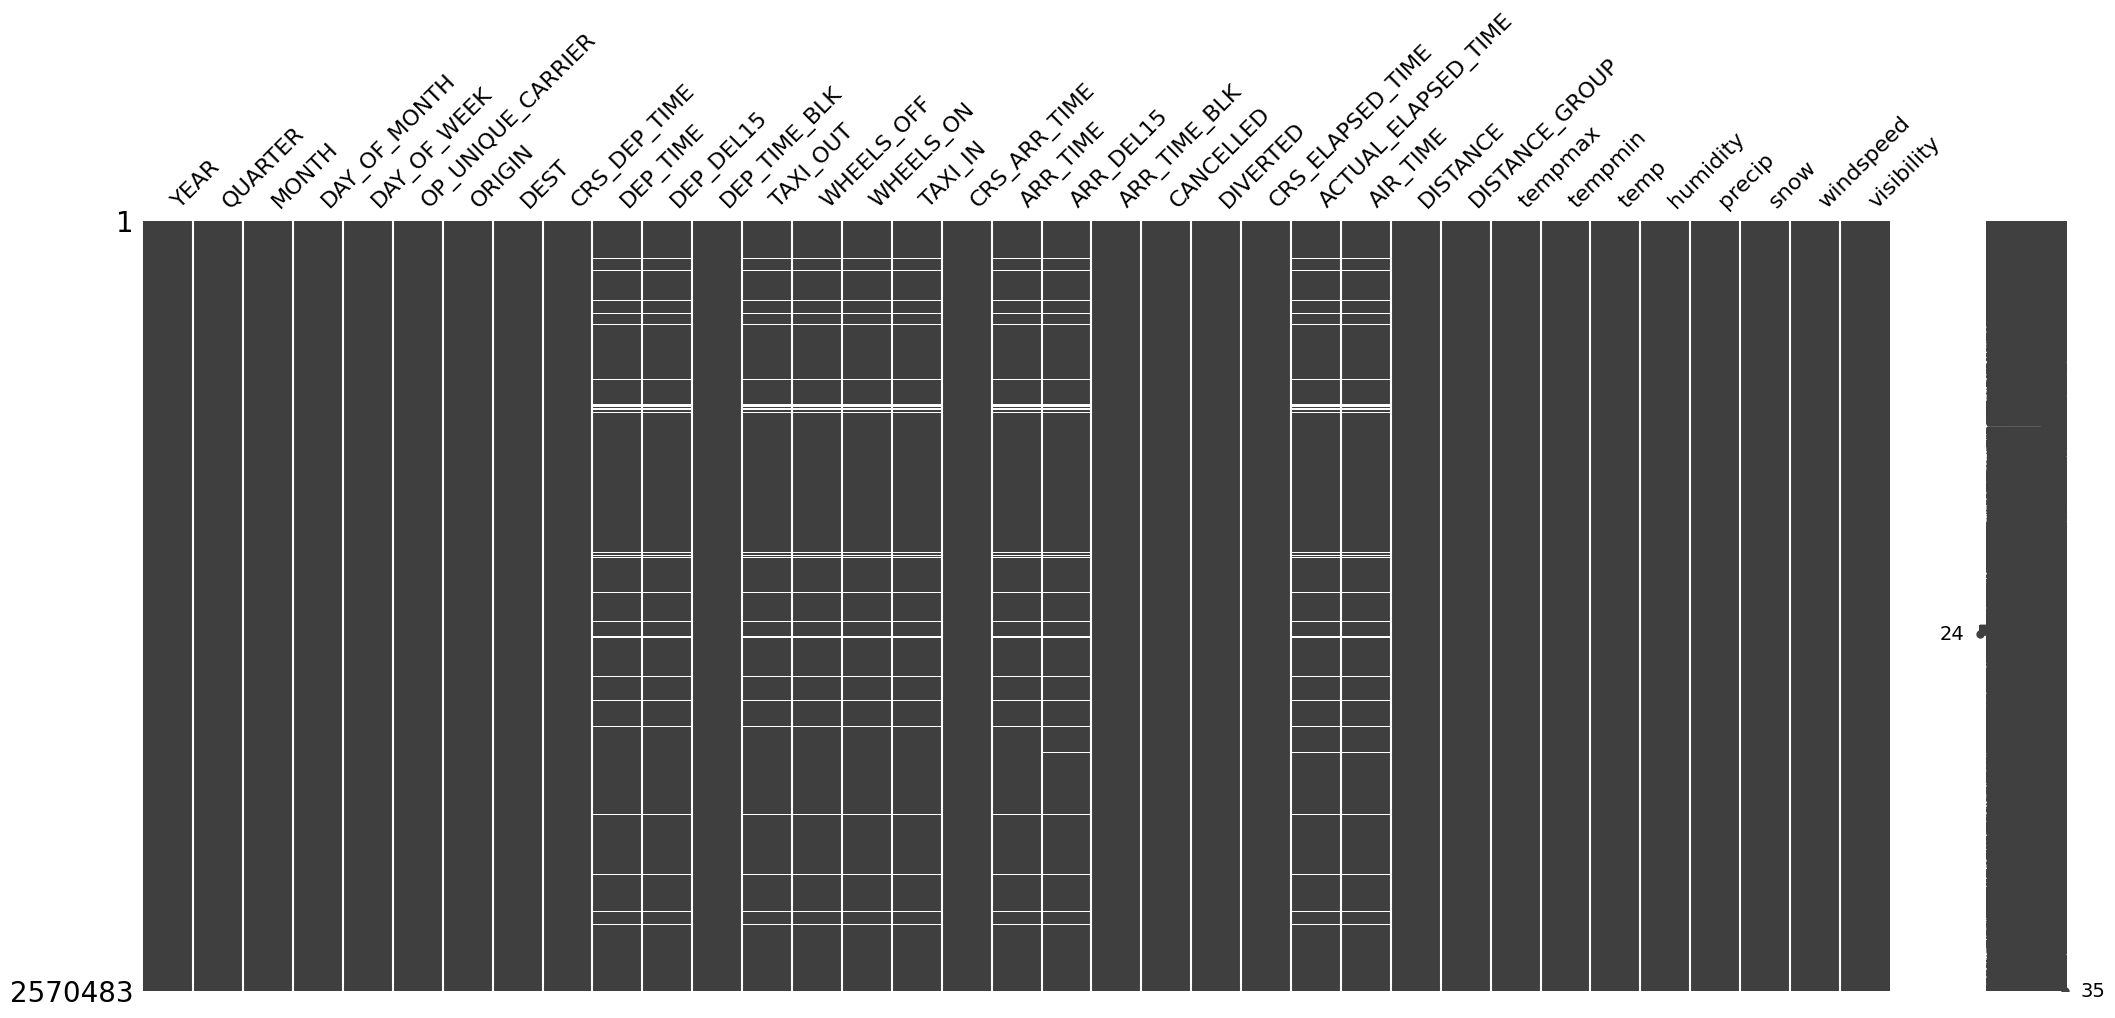

In [ ]:
import missingno as msno

# Visualize the missingness pattern for the entire dataframe
msno.matrix(dp)

# Visualize the missingness pattern for specific columns
# msno.matrix(dp[['col1', 'col2']])

In [ ]:
dp = dp.dropna()

In [ ]:
cols_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST',
                'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DEL15',
                'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
                'ARR_DEL15','ARR_TIME_BLK',
                'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
                'DISTANCE_GROUP','tempmax','tempmin', 'temp', 'humidity', 'precip', 'snow', 'windspeed',
                'visibility']

In [ ]:
dp = dp[cols_to_keep]

In [ ]:
dp

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,tempmax,tempmin,temp,humidity,precip,snow,windspeed,visibility
0,2022,1,1,1,6,AA,ORD,SLC,1015,1013.0,0.0,1000-1059,15.0,1028.0,1237.0,12.0,1255,1249.0,0.0,1200-1259,220.0,216.0,189.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
1,2022,1,1,1,6,AA,SLC,ORD,1340,1428.0,1.0,1300-1359,16.0,1444.0,1817.0,15.0,1752,1832.0,1.0,1700-1759,192.0,184.0,153.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
2,2022,1,1,1,6,AA,ORD,BWI,1847,2006.0,1.0,1800-1859,31.0,2037.0,2257.0,9.0,2132,2306.0,1.0,2100-2159,105.0,120.0,80.0,621.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
7,2022,1,1,1,6,AA,ORD,BNA,1240,1826.0,1.0,1200-1259,107.0,2013.0,2122.0,5.0,1408,2127.0,1.0,1400-1459,88.0,181.0,69.0,409.0,2,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
8,2022,1,1,1,6,AA,BWI,ORD,1034,1027.0,0.0,1000-1059,11.0,1038.0,1128.0,6.0,1155,1134.0,0.0,1100-1159,141.0,127.0,110.0,621.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570478,2018,4,12,31,1,YX,ORD,MCI,1005,1017.0,0.0,1000-1059,38.0,1055.0,1208.0,6.0,1146,1214.0,1.0,1100-1159,101.0,117.0,73.0,403.0,2,40.5,33.0,37.0,90.2,0.695,0.0,20.4,5.8
2570479,2018,4,12,31,1,YX,ORD,DFW,1014,1009.0,0.0,1000-1059,44.0,1053.0,1313.0,12.0,1300,1325.0,1.0,1300-1359,166.0,196.0,140.0,801.0,4,40.5,33.0,37.0,90.2,0.695,0.0,20.4,5.8
2570480,2018,4,12,31,1,YX,DSM,ORD,754,744.0,0.0,0700-0759,21.0,805.0,857.0,34.0,929,931.0,0.0,0900-0959,95.0,107.0,52.0,299.0,2,40.5,33.0,37.0,90.2,0.695,0.0,20.4,5.8
2570481,2018,4,12,31,1,YX,ORD,JFK,1040,1037.0,0.0,1000-1059,34.0,1111.0,1341.0,11.0,1357,1352.0,0.0,1300-1359,137.0,135.0,90.0,740.0,3,40.5,33.0,37.0,90.2,0.695,0.0,20.4,5.8


# 4. Encoding Categorical Features 

In [ ]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2486145 entries, 0 to 2570482
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   QUARTER              int64  
 2   MONTH                int64  
 3   DAY_OF_MONTH         int64  
 4   DAY_OF_WEEK          int64  
 5   OP_UNIQUE_CARRIER    object 
 6   ORIGIN               object 
 7   DEST                 object 
 8   CRS_DEP_TIME         int64  
 9   DEP_TIME             float64
 10  DEP_DEL15            float64
 11  DEP_TIME_BLK         object 
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  WHEELS_ON            float64
 15  TAXI_IN              float64
 16  CRS_ARR_TIME         int64  
 17  ARR_TIME             float64
 18  ARR_DEL15            float64
 19  ARR_TIME_BLK         object 
 20  CRS_ELAPSED_TIME     float64
 21  ACTUAL_ELAPSED_TIME  float64
 22  AIR_TIME             float64
 23  DISTANCE             float64
 24

## Using label encoder 

In [ ]:
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

# encode the categorical variables
dp['ORIGIN'] = le.fit_transform(dp['ORIGIN'])
dp['DEST'] = le.fit_transform(dp['DEST'])
dp['OP_UNIQUE_CARRIER'] = le.fit_transform(dp['OP_UNIQUE_CARRIER'])
dp['DEP_TIME_BLK'] = le.fit_transform(dp['DEP_TIME_BLK'])
dp['ARR_TIME_BLK'] = le.fit_transform(dp['ARR_TIME_BLK'])



In [ ]:
dp.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,tempmax,tempmin,temp,humidity,precip,snow,windspeed,visibility
0,2022,1,1,1,6,1,143,181,1015,1013.0,0.0,5,15.0,1028.0,1237.0,12.0,1255,1249.0,0.0,7,220.0,216.0,189.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
1,2022,1,1,1,6,1,179,145,1340,1428.0,1.0,8,16.0,1444.0,1817.0,15.0,1752,1832.0,1.0,12,192.0,184.0,153.0,1250.0,6,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
2,2022,1,1,1,6,1,143,29,1847,2006.0,1.0,13,31.0,2037.0,2257.0,9.0,2132,2306.0,1.0,16,105.0,120.0,80.0,621.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
7,2022,1,1,1,6,1,143,23,1240,1826.0,1.0,7,107.0,2013.0,2122.0,5.0,1408,2127.0,1.0,9,88.0,181.0,69.0,409.0,2,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8
8,2022,1,1,1,6,1,29,145,1034,1027.0,0.0,5,11.0,1038.0,1128.0,6.0,1155,1134.0,0.0,6,141.0,127.0,110.0,621.0,3,41.7,30.7,35.5,80.8,0.055,0.0,23.8,4.8


## Feature selection

In [ ]:
X= dp.drop('ARR_DEL15', axis=1)
Y= dp['ARR_DEL15']

In [ ]:
corr1 = X.corr()

<AxesSubplot: >

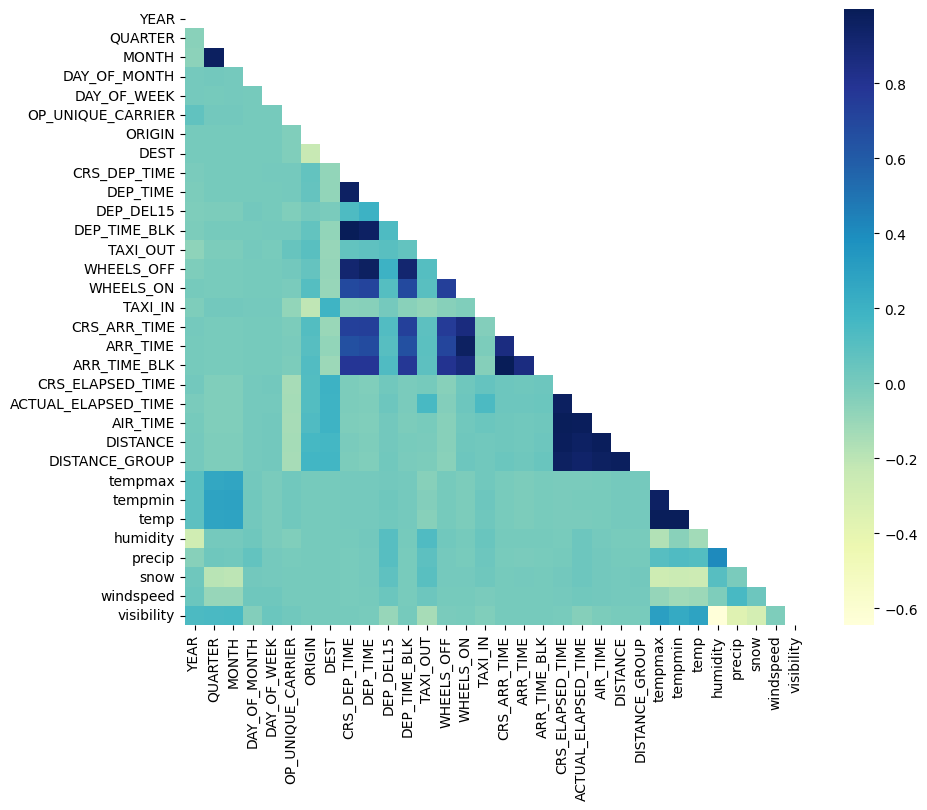

In [ ]:
plt.figure(figsize = (10,8))
mask = np.triu(np.ones_like(corr1, dtype=bool))
sns.heatmap(corr1, cmap="YlGnBu", mask=mask)

In [ ]:
# Import your necessary dependencies
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X,Y)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


Ridge(normalize=False)

In [ ]:
def pretty_print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [ ]:
print ("Ridge model:", pretty_print_coefs(ridge.coef_))

Ridge model: 0.002 * X0 + -0.001 * X1 + -0.0 * X2 + 0.0 * X3 + 0.0 * X4 + -0.001 * X5 + 0.0 * X6 + -0.0 * X7 + -0.0 * X8 + 0.0 * X9 + 0.715 * X10 + 0.003 * X11 + -0.03 * X12 + 0.0 * X13 + -0.0 * X14 + -0.031 * X15 + 0.0 * X16 + -0.0 * X17 + -0.002 * X18 + -0.007 * X19 + 0.04 * X20 + -0.032 * X21 + -0.0 * X22 + 0.002 * X23 + 0.0 * X24 + 0.0 * X25 + 0.0 * X26 + 0.0 * X27 + 0.016 * X28 + 0.027 * X29 + 0.001 * X30 + -0.002 * X31


In [ ]:
feature_names = X.columns.tolist()
abs_coefs = np.abs(ridge.coef_)
coefs_sorted = sorted(zip(abs_coefs, feature_names), reverse=True)

In [ ]:
coefs_sorted = coefs_sorted[:40]
feature_names_sorted = [x[1] for x in coefs_sorted]

In [ ]:
feature_names_sorted

['DEP_DEL15',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'TAXI_IN',
 'TAXI_OUT',
 'snow',
 'precip',
 'CRS_ELAPSED_TIME',
 'DEP_TIME_BLK',
 'visibility',
 'ARR_TIME_BLK',
 'YEAR',
 'DISTANCE_GROUP',
 'QUARTER',
 'OP_UNIQUE_CARRIER',
 'windspeed',
 'humidity',
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DISTANCE',
 'temp',
 'tempmin',
 'CRS_ARR_TIME',
 'DAY_OF_MONTH',
 'DEST',
 'ARR_TIME',
 'WHEELS_OFF',
 'WHEELS_ON',
 'ORIGIN',
 'tempmax']

In [ ]:
cols_to_keep = ['ARR_DEL15','DEP_DEL15','ACTUAL_ELAPSED_TIME','AIR_TIME','TAXI_IN','TAXI_OUT','snow','precip','CRS_ELAPSED_TIME','DEP_TIME_BLK','visibility','ARR_TIME_BLK','YEAR','DISTANCE_GROUP',
                'QUARTER','OP_UNIQUE_CARRIER','windspeed','humidity','MONTH','DAY_OF_WEEK','CRS_DEP_TIME','DEP_TIME','DISTANCE','temp','tempmin','CRS_ARR_TIME','DAY_OF_MONTH','DEST',
                'ARR_TIME','WHEELS_OFF','WHEELS_ON','ORIGIN','tempmax']

In [ ]:
dp = dp[cols_to_keep]
dp.head()

,ARR_DEL15,DEP_DEL15,ACTUAL_ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT,snow,precip,CRS_ELAPSED_TIME,DEP_TIME_BLK,visibility,ARR_TIME_BLK,YEAR,DISTANCE_GROUP,QUARTER,OP_UNIQUE_CARRIER,windspeed,humidity,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DISTANCE,temp,tempmin,CRS_ARR_TIME,DAY_OF_MONTH,DEST,ARR_TIME,WHEELS_OFF,WHEELS_ON,ORIGIN,tempmax
0,0.0,0.0,216.0,189.0,12.0,15.0,0.0,0.055,220.0,5,4.8,7,2022,6,1,1,23.8,80.8,1,6,1015,1013.0,1250.0,35.5,30.7,1255,1,181,1249.0,1028.0,1237.0,143,41.7
1,1.0,1.0,184.0,153.0,15.0,16.0,0.0,0.055,192.0,8,4.8,12,2022,6,1,1,23.8,80.8,1,6,1340,1428.0,1250.0,35.5,30.7,1752,1,145,1832.0,1444.0,1817.0,179,41.7
2,1.0,1.0,120.0,80.0,9.0,31.0,0.0,0.055,105.0,13,4.8,16,2022,3,1,1,23.8,80.8,1,6,1847,2006.0,621.0,35.5,30.7,2132,1,29,2306.0,2037.0,2257.0,143,41.7
7,1.0,1.0,181.0,69.0,5.0,107.0,0.0,0.055,88.0,7,4.8,9,2022,2,1,1,23.8,80.8,1,6,1240,1826.0,409.0,35.5,30.7,1408,1,23,2127.0,2013.0,2122.0,143,41.7
8,0.0,0.0,127.0,110.0,6.0,11.0,0.0,0.055,141.0,5,4.8,6,2022,3,1,1,23.8,80.8,1,6,1034,1027.0,621.0,35.5,30.7,1155,1,145,1134.0,1038.0,1128.0,29,41.7


# Model Building

## train test split

In [ ]:
X= dp.drop('ARR_DEL15', axis=1)
Y= dp['ARR_DEL15']

In [ ]:
dp['ARR_DEL15'].value_counts()

0.0    1999143
1.0     487002
Name: ARR_DEL15, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

In [ ]:
X_train

,DEP_DEL15,ACTUAL_ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT,snow,precip,CRS_ELAPSED_TIME,DEP_TIME_BLK,visibility,ARR_TIME_BLK,YEAR,DISTANCE_GROUP,QUARTER,OP_UNIQUE_CARRIER,windspeed,humidity,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DISTANCE,temp,tempmin,CRS_ARR_TIME,DAY_OF_MONTH,DEST,ARR_TIME,WHEELS_OFF,WHEELS_ON,ORIGIN,tempmax
1805675,0.0,122.0,86.0,16.0,20.0,0.0,0.039,128.0,13,9.8,16,2019,3,3,12,12.8,71.2,9,7,1810,1806.0,678.0,65.1,62.8,2118,8,150,2108.0,1826.0,2052.0,143,67.8
1413589,0.0,132.0,114.0,8.0,10.0,0.2,0.002,157.0,7,8.5,9,2019,4,1,7,24.6,76.4,2,3,1237,1224.0,760.0,20.3,12.5,1414,13,145,1336.0,1234.0,1328.0,36,28.4
1257716,0.0,138.0,116.0,8.0,14.0,0.0,0.000,135.0,6,9.9,8,2021,4,4,14,12.5,54.1,11,5,1100,1106.0,798.0,42.7,34.1,1315,5,145,1324.0,1120.0,1316.0,50,51.9
1648721,0.0,196.0,167.0,3.0,26.0,0.0,0.000,190.0,5,9.9,7,2019,5,2,1,13.9,60.1,6,5,1025,1020.0,1162.0,63.1,53.1,1235,21,100,1236.0,1046.0,1233.0,143,71.8
1436765,0.0,151.0,122.0,12.0,17.0,0.0,0.000,140.0,5,9.4,7,2019,3,1,10,16.7,64.6,2,2,1045,1040.0,642.0,21.5,17.3,1205,26,145,1211.0,1057.0,1159.0,160,24.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336757,1.0,148.0,101.0,9.0,38.0,0.0,0.000,144.0,6,9.9,8,2022,3,3,12,8.8,55.7,8,2,1140,1904.0,678.0,75.5,64.9,1304,23,145,2032.0,1942.0,2023.0,148,84.4
1257580,0.0,221.0,194.0,15.0,12.0,0.0,0.000,235.0,9,9.9,15,2021,7,4,12,12.5,54.1,11,5,1418,1416.0,1739.0,42.7,34.1,2013,5,145,1957.0,1428.0,1942.0,147,51.9
2232015,0.0,273.0,215.0,13.0,45.0,0.0,1.093,260.0,5,6.6,7,2018,7,2,12,17.2,91.4,6,5,1017,1017.0,1744.0,62.5,60.9,1237,22,109,1250.0,1102.0,1237.0,143,65.6
1451426,0.0,171.0,130.0,15.0,26.0,0.0,0.000,179.0,14,9.9,16,2019,4,1,1,12.5,60.8,3,4,1925,1931.0,867.0,23.3,16.6,2124,7,145,2122.0,1957.0,2107.0,25,28.0


In [ ]:
y_train

1805675    0.0
1413589    0.0
1257716    0.0
1648721    0.0
1436765    0.0
          ... 
336757     1.0
1257580    0.0
2232015    0.0
1451426    0.0
1466500    0.0
Name: ARR_DEL15, Length: 1988916, dtype: float64

## Scaling

In [ ]:
dp_scale = X_train

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dp_scaled = scaler.fit_transform(dp_scale)

dp_scaled = pd.DataFrame(dp_scaled, columns=dp_scale.columns)

X_train = dp_scaled
X_train.head()

,DEP_DEL15,ACTUAL_ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT,snow,precip,CRS_ELAPSED_TIME,DEP_TIME_BLK,visibility,ARR_TIME_BLK,YEAR,DISTANCE_GROUP,QUARTER,OP_UNIQUE_CARRIER,windspeed,humidity,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DISTANCE,temp,tempmin,CRS_ARR_TIME,DAY_OF_MONTH,DEST,ARR_TIME,WHEELS_OFF,WHEELS_ON,ORIGIN,tempmax
0,-0.465128,-0.271943,-0.385656,0.815491,0.046635,-0.16969,-0.229066,-0.264242,1.127790,0.478445,1.340467,-0.605607,-0.282989,0.400744,0.839050,-0.723154,0.477942,0.692328,1.514676,1.084395,1.036326,-0.188869,0.568991,0.842642,1.286926,-0.879885,0.595688,1.251836,1.018217,1.169407,0.483462,0.308016
1,-0.465128,-0.112355,0.072121,-0.263624,-0.880949,1.05147,-0.376792,0.200836,-0.153642,-0.531445,-0.108560,-0.605607,0.226268,-1.406897,-0.241940,1.750699,0.900085,-1.381826,-0.486691,-0.124983,-0.159347,-0.030768,-1.696493,-1.766335,-0.123568,-0.308566,0.486437,-0.238298,-0.190829,-0.238661,-1.892770,-1.580307
2,-0.465128,-0.016602,0.104819,-0.263624,-0.509915,-0.16969,-0.384777,-0.151982,-0.367214,0.556128,-0.315564,0.790537,0.226268,1.304564,1.271445,-0.786049,-0.910262,1.284943,0.513993,-0.414136,-0.401769,0.042499,-0.563751,-0.645979,-0.321918,-1.222677,0.486437,-0.261461,-0.423652,-0.261999,-1.581861,-0.454023
3,-0.465128,0.909007,0.938626,-0.938071,0.603185,-0.16969,-0.384777,0.730063,-0.580786,0.556128,-0.522568,-0.605607,0.735525,-0.503076,-1.539127,-0.492541,-0.423173,-0.196595,0.513993,-0.572431,-0.578449,0.744315,0.467854,0.339519,-0.482202,0.605544,-0.496821,-0.431321,-0.574782,-0.423421,0.483462,0.499723
4,-0.465128,0.190862,0.202914,0.275934,-0.231640,-0.16969,-0.384777,-0.071796,-0.580786,0.167709,-0.522568,-0.605607,-0.282989,-1.406897,0.406654,0.094475,-0.057856,-1.381826,-0.987032,-0.530219,-0.537360,-0.258280,-1.635810,-1.517367,-0.542308,1.176863,0.486437,-0.479577,-0.552317,-0.567340,0.860994,-1.762429


In [ ]:
dp_scale1 = X_test

from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
dp_scaled1 = scaler1.fit_transform(dp_scale1)

dp_scaled1 = pd.DataFrame(dp_scaled1, columns=dp_scale1.columns)

X_test = dp_scaled1
X_test.head()

,DEP_DEL15,ACTUAL_ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT,snow,precip,CRS_ELAPSED_TIME,DEP_TIME_BLK,visibility,ARR_TIME_BLK,YEAR,DISTANCE_GROUP,QUARTER,OP_UNIQUE_CARRIER,windspeed,humidity,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DISTANCE,temp,tempmin,CRS_ARR_TIME,DAY_OF_MONTH,DEST,ARR_TIME,WHEELS_OFF,WHEELS_ON,ORIGIN,tempmax
0,-0.463902,-1.023615,-0.943615,-0.396483,-0.324807,-0.169342,-0.383922,-0.956243,0.054929,0.554912,0.094114,1.493828,-0.793360,0.401225,1.703103,-1.355385,-0.663939,0.100376,-1.487863,0.023999,-0.000109,-0.890867,1.358942,1.274250,0.114773,0.265574,-1.823896,0.110998,-0.020271,0.115286,0.483221,1.358596
1,-0.463902,0.958201,0.219522,7.287368,-0.695444,-0.169342,-0.383922,0.554583,0.909687,0.554912,0.715754,-0.603422,-0.283681,0.401225,0.406405,0.574997,-0.347180,0.100376,1.515338,0.847908,0.721833,-0.082908,1.404433,1.377922,0.764179,1.410307,0.488259,0.873623,0.770958,0.694979,-0.251209,1.358596
2,-0.463902,-1.119510,-1.254877,1.625583,-0.510126,-0.169342,-0.383922,-1.116969,0.054929,0.554912,-0.320312,1.493828,-1.303039,0.401225,0.406405,0.155349,-1.126895,0.396469,1.014805,0.023999,-0.006279,-1.234927,1.070833,1.196496,-0.306138,-0.306793,0.488259,-0.292518,-0.030494,-0.398269,-0.852106,0.884264
3,-0.463902,-0.336373,-0.419384,0.007930,0.416466,-0.169342,-0.383922,-0.490137,0.054929,0.554912,0.094114,1.493828,-0.793360,1.304473,-0.241944,1.770994,-1.232482,0.988655,1.515338,0.100052,0.084221,-0.550674,0.914142,0.937317,0.124795,0.837941,0.488259,0.157334,0.161691,0.156136,-0.006399,0.917802
4,-0.463902,-0.096637,-0.058975,-0.935701,0.416466,-0.169342,-0.055971,-0.024031,1.123376,0.167090,1.337394,0.095661,0.225999,-0.502024,-0.674176,-0.411176,1.431546,-0.787902,1.014805,1.090855,1.036525,0.239889,-0.496075,-0.441520,1.323389,-1.337053,0.750012,1.273278,1.026523,1.294126,0.483221,-0.078775


------------------------------

## Modeling and Evaluation

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])

In [ ]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
# svm = SVC(probability=True)
xgb = XGBClassifier()


LogisticRegression Feature Importance:
1. DEP_DEL15: 2.9731
2. ACTUAL_ELAPSED_TIME: 5.7095
3. AIR_TIME: 5.5364
4. TAXI_IN: 0.7391
5. TAXI_OUT: 1.2662
6. snow: 0.0575
7. precip: 0.0686
8. CRS_ELAPSED_TIME: -10.7900
9. DEP_TIME_BLK: 0.1791
10. visibility: -0.0224
11. ARR_TIME_BLK: -0.4798
12. YEAR: 0.0216
13. DISTANCE_GROUP: 0.1229
14. QUARTER: -0.0292
15. OP_UNIQUE_CARRIER: -0.0222
16. windspeed: 0.0524
17. humidity: 0.0850
18. MONTH: 0.0054
19. DAY_OF_WEEK: 0.0026
20. CRS_DEP_TIME: -0.5035
21. DEP_TIME: 0.5453
22. DISTANCE: -0.5131
23. temp: -0.0500
24. tempmin: 0.0946
25. CRS_ARR_TIME: 0.5680
26. DAY_OF_MONTH: 0.0041
27. DEST: -0.0210
28. ARR_TIME: -0.1019
29. WHEELS_OFF: 0.0929
30. WHEELS_ON: -0.1542
31. ORIGIN: 0.0089
32. tempmax: 0.0256


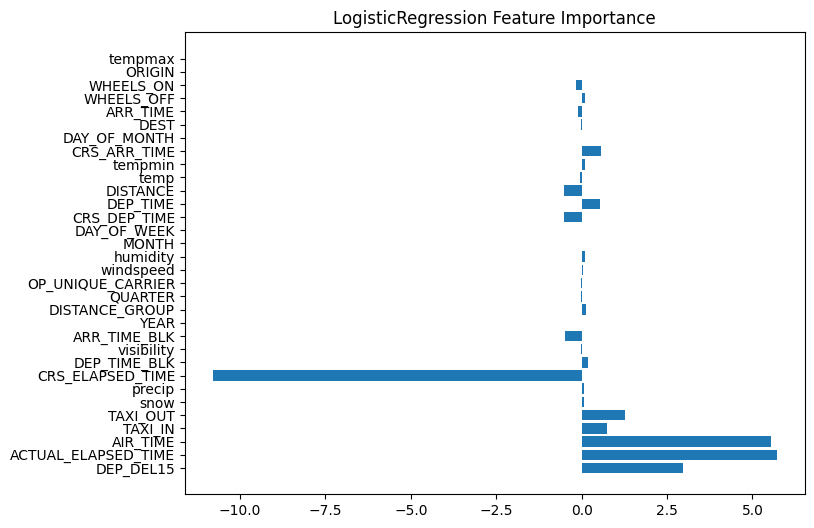


DecisionTreeClassifier Feature Importance:
1. DEP_DEL15: 0.5318
2. ACTUAL_ELAPSED_TIME: 0.0460
3. AIR_TIME: 0.0095
4. TAXI_IN: 0.0325
5. TAXI_OUT: 0.1036
6. snow: 0.0010
7. precip: 0.0068
8. CRS_ELAPSED_TIME: 0.0520
9. DEP_TIME_BLK: 0.0013
10. visibility: 0.0036
11. ARR_TIME_BLK: 0.0015
12. YEAR: 0.0026
13. DISTANCE_GROUP: 0.0004
14. QUARTER: 0.0009
15. OP_UNIQUE_CARRIER: 0.0037
16. windspeed: 0.0079
17. humidity: 0.0077
18. MONTH: 0.0029
19. DAY_OF_WEEK: 0.0033
20. CRS_DEP_TIME: 0.0069
21. DEP_TIME: 0.0061
22. DISTANCE: 0.0043
23. temp: 0.0044
24. tempmin: 0.0056
25. CRS_ARR_TIME: 0.0620
26. DAY_OF_MONTH: 0.0062
27. DEST: 0.0036
28. ARR_TIME: 0.0523
29. WHEELS_OFF: 0.0054
30. WHEELS_ON: 0.0154
31. ORIGIN: 0.0034
32. tempmax: 0.0052


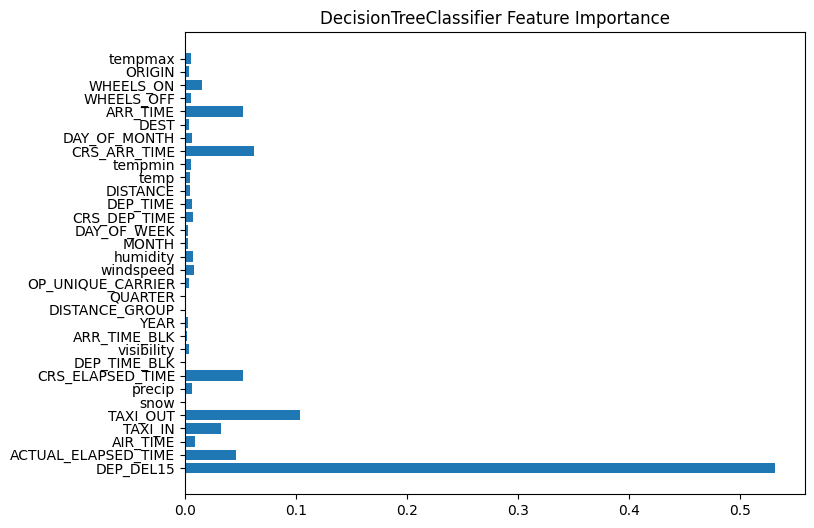


RandomForestClassifier Feature Importance:
1. DEP_DEL15: 0.4078
2. ACTUAL_ELAPSED_TIME: 0.0294
3. AIR_TIME: 0.0168
4. TAXI_IN: 0.0301
5. TAXI_OUT: 0.0938
6. snow: 0.0018
7. precip: 0.0125
8. CRS_ELAPSED_TIME: 0.0292
9. DEP_TIME_BLK: 0.0171
10. visibility: 0.0085
11. ARR_TIME_BLK: 0.0217
12. YEAR: 0.0042
13. DISTANCE_GROUP: 0.0050
14. QUARTER: 0.0021
15. OP_UNIQUE_CARRIER: 0.0054
16. windspeed: 0.0086
17. humidity: 0.0128
18. MONTH: 0.0046
19. DAY_OF_WEEK: 0.0045
20. CRS_DEP_TIME: 0.0322
21. DEP_TIME: 0.0251
22. DISTANCE: 0.0129
23. temp: 0.0091
24. tempmin: 0.0089
25. CRS_ARR_TIME: 0.0495
26. DAY_OF_MONTH: 0.0071
27. DEST: 0.0063
28. ARR_TIME: 0.0489
29. WHEELS_OFF: 0.0309
30. WHEELS_ON: 0.0383
31. ORIGIN: 0.0058
32. tempmax: 0.0090


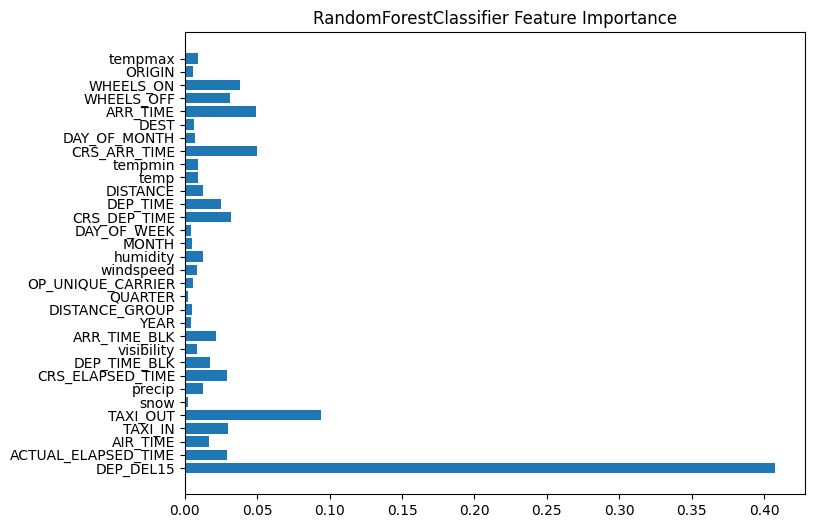


XGBClassifier Feature Importance:
1. DEP_DEL15: 0.4079
2. ACTUAL_ELAPSED_TIME: 0.0356
3. AIR_TIME: 0.0355
4. TAXI_IN: 0.0935
5. TAXI_OUT: 0.1448
6. snow: 0.0007
7. precip: 0.0276
8. CRS_ELAPSED_TIME: 0.0456
9. DEP_TIME_BLK: 0.0108
10. visibility: 0.0020
11. ARR_TIME_BLK: 0.0121
12. YEAR: 0.0172
13. DISTANCE_GROUP: 0.0005
14. QUARTER: 0.0003
15. OP_UNIQUE_CARRIER: 0.0114
16. windspeed: 0.0014
17. humidity: 0.0069
18. MONTH: 0.0020
19. DAY_OF_WEEK: 0.0016
20. CRS_DEP_TIME: 0.0252
21. DEP_TIME: 0.0117
22. DISTANCE: 0.0006
23. temp: 0.0017
24. tempmin: 0.0033
25. CRS_ARR_TIME: 0.0304
26. DAY_OF_MONTH: 0.0003
27. DEST: 0.0053
28. ARR_TIME: 0.0241
29. WHEELS_OFF: 0.0111
30. WHEELS_ON: 0.0199
31. ORIGIN: 0.0044
32. tempmax: 0.0048


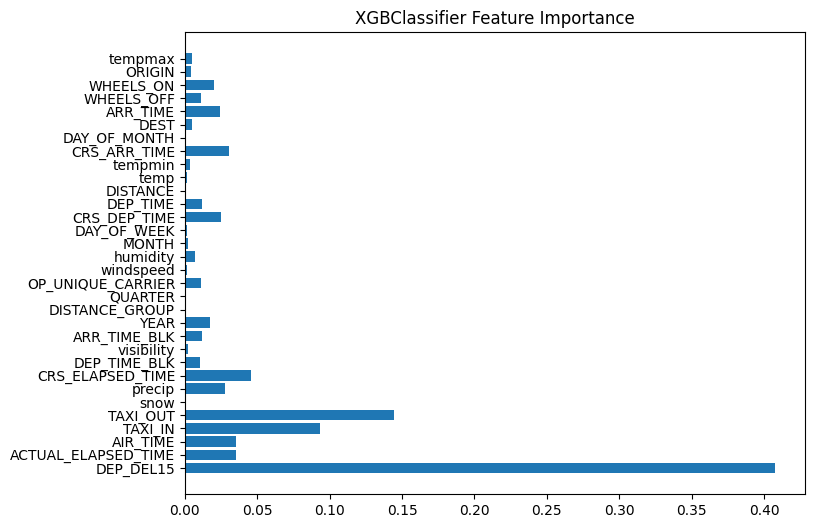

In [ ]:
for model in [lr, dt, rf, xgb]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculating performance metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred), 2)
    recall = round(recall_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)
    auc_roc = round(roc_auc_score(y_test, y_prob), 2)
    
    # Extracting feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importance = model.coef_.flatten()
    else:
        feature_importance = None
    
    # Adding results to the dataframe
    results_df = results_df.append({'Model': type(model).__name__, 'Accuracy': accuracy, 
                                    'Precision': precision, 'Recall': recall, 
                                    'F1-score': f1, 'AUC-ROC': auc_roc}, ignore_index=True)
                                    #'Feature Importance': feature_importance}, ignore_index=True#

    # Displaying feature importance separately for each model
    if feature_importance is not None:
        print(f"\n{type(model).__name__} Feature Importance:")
        for i, feat in enumerate(feature_importance):
            print(f"{i+1}. {X_train.columns[i]}: {feat:.4f}")
            
        # Plotting feature importance separately for each model
    if feature_importance is not None:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.barh(X_train.columns, feature_importance)
        ax.set_title(f"{type(model).__name__} Feature Importance")
        plt.show()

In [ ]:
results_df.sort_values(by='F1-score', ascending=False, inplace=True)

In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC-ROC
3,XGBClassifier,0.99,0.97,0.95,0.96,1.00
2,RandomForestClassifier,0.97,0.94,0.89,0.92,0.99
1,DecisionTreeClassifier,0.96,0.89,0.89,0.89,0.93
0,LogisticRegression,0.95,0.87,0.85,0.86,0.98


--------------------------------------------

## Model performance when there is departure delay  

In [ ]:
dp_del = dp

In [ ]:
dp_del = dp_del.drop(dp_del[dp_del['DEP_DEL15'] == 0].index)

In [ ]:
dp_del

,ARR_DEL15,DEP_DEL15,ACTUAL_ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT,snow,precip,CRS_ELAPSED_TIME,DEP_TIME_BLK,visibility,ARR_TIME_BLK,YEAR,DISTANCE_GROUP,QUARTER,OP_UNIQUE_CARRIER,windspeed,humidity,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DISTANCE,temp,tempmin,CRS_ARR_TIME,DAY_OF_MONTH,DEST,ARR_TIME,WHEELS_OFF,WHEELS_ON,ORIGIN,tempmax
1,1.0,1.0,184.0,153.0,15.0,16.0,0.0,0.055,192.0,8,4.8,12,2022,6,1,1,23.8,80.8,1,6,1340,1428.0,1250.0,35.5,30.7,1752,1,145,1832.0,1444.0,1817.0,179,41.7
2,1.0,1.0,120.0,80.0,9.0,31.0,0.0,0.055,105.0,13,4.8,16,2022,3,1,1,23.8,80.8,1,6,1847,2006.0,621.0,35.5,30.7,2132,1,29,2306.0,2037.0,2257.0,143,41.7
7,1.0,1.0,181.0,69.0,5.0,107.0,0.0,0.055,88.0,7,4.8,9,2022,2,1,1,23.8,80.8,1,6,1240,1826.0,409.0,35.5,30.7,1408,1,23,2127.0,2013.0,2122.0,143,41.7
22,1.0,1.0,174.0,145.0,7.0,22.0,0.0,0.055,188.0,4,4.8,6,2022,5,1,1,23.8,80.8,1,6,930,1019.0,1005.0,35.5,30.7,1138,1,145,1213.0,1041.0,1206.0,117,41.7
23,1.0,1.0,169.0,135.0,4.0,30.0,0.0,0.055,160.0,7,4.8,11,2022,5,1,1,23.8,80.8,1,6,1240,1330.0,1005.0,35.5,30.7,1620,1,119,1719.0,1400.0,1715.0,143,41.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570451,1.0,1.0,156.0,131.0,12.0,13.0,0.0,0.695,148.0,2,5.8,3,2018,3,4,16,20.4,90.2,12,1,730,753.0,717.0,37.0,33.0,858,31,145,929.0,806.0,917.0,144,40.5
2570455,1.0,1.0,113.0,72.0,13.0,28.0,0.0,0.695,108.0,13,5.8,15,2018,2,4,16,20.4,90.2,12,1,1815,1831.0,463.0,37.0,33.0,2003,31,145,2024.0,1859.0,2011.0,78,40.5
2570465,1.0,1.0,129.0,51.0,8.0,70.0,0.0,0.695,81.0,12,5.8,15,2018,2,4,16,20.4,90.2,12,1,1755,1817.0,296.0,37.0,33.0,2016,31,41,2126.0,1927.0,2118.0,143,40.5
2570466,1.0,1.0,189.0,146.0,18.0,25.0,0.0,0.695,171.0,8,5.8,12,2018,5,4,16,20.4,90.2,12,1,1318,1333.0,1236.0,37.0,33.0,1709,31,145,1742.0,1358.0,1724.0,65,40.5


In [ ]:
X1= dp_del.drop(['ARR_DEL15','DEP_DEL15'], axis=1)
Y1= dp_del['ARR_DEL15']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.2, random_state=11)

In [ ]:
dp_scale = X_train

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dp_scaled = scaler.fit_transform(dp_scale)

dp_scaled = pd.DataFrame(dp_scaled, columns=dp_scale.columns)

X_train = dp_scaled
X_train.head()

,ACTUAL_ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT,snow,precip,CRS_ELAPSED_TIME,DEP_TIME_BLK,visibility,ARR_TIME_BLK,YEAR,DISTANCE_GROUP,QUARTER,OP_UNIQUE_CARRIER,windspeed,humidity,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DISTANCE,temp,tempmin,CRS_ARR_TIME,DAY_OF_MONTH,DEST,ARR_TIME,WHEELS_OFF,WHEELS_ON,ORIGIN,tempmax
0,1.513125,1.640846,0.368437,-0.568201,-0.221932,3.626338,1.563591,2.004366,-0.012818,-2.079903,0.827927,1.729286,-0.479578,-1.252995,0.293602,1.248577,-0.161636,0.988543,2.046503,-3.074961,1.809012,0.963205,1.125353,-2.014984,1.161275,0.508079,-1.569508,-3.042231,-1.627344,1.160110,0.897211
1,1.592997,1.904757,-0.617754,-0.788277,-0.221932,0.494181,2.094271,-0.021066,-1.058134,0.245965,-0.532245,2.241446,-0.479578,0.905938,-1.196229,1.216170,-0.465730,-0.485964,-0.021142,0.286057,2.052621,0.323392,0.221256,0.196246,1.505564,1.175087,0.461583,0.250647,0.461011,0.477257,0.521092
2,-1.298354,-1.130214,-0.001385,-0.934995,-0.221932,-0.493727,-1.009403,0.429030,0.117846,0.034522,0.147841,-1.343675,1.386251,0.474152,2.508216,-0.906549,1.662925,0.005539,0.389722,0.281887,-1.087007,-1.817157,-1.720878,0.059800,0.931748,0.508079,0.122789,0.242460,0.106417,-1.411970,-1.574428
3,0.985973,1.244981,-0.124658,-0.934995,-0.221932,-0.474293,1.467104,2.004366,-1.646125,-2.291346,-1.212331,1.729286,-0.479578,0.042365,-1.478089,1.410617,-0.161636,-0.977466,2.017631,1.766406,1.809012,0.817365,0.819203,-2.133371,-0.445411,0.508079,-1.754759,-3.130232,-1.809756,1.160110,0.803181
4,-0.148203,-0.008594,-0.617754,-0.274766,-0.221932,0.400249,-0.092774,0.879126,0.575172,1.091735,0.827927,0.192805,-0.479578,0.905938,-1.457956,0.592317,-0.161636,-0.485964,0.811690,0.657187,0.144678,0.991432,1.206674,1.036995,1.620328,-2.073891,0.943904,0.629256,0.953692,0.477257,0.839002


In [ ]:
dp_scale1 = X_test

from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
dp_scaled1 = scaler1.fit_transform(dp_scale1)

dp_scaled1 = pd.DataFrame(dp_scaled1, columns=dp_scale1.columns)

X_test = dp_scaled1
X_test.head()

,ACTUAL_ELAPSED_TIME,AIR_TIME,TAXI_IN,TAXI_OUT,snow,precip,CRS_ELAPSED_TIME,DEP_TIME_BLK,visibility,ARR_TIME_BLK,YEAR,DISTANCE_GROUP,QUARTER,OP_UNIQUE_CARRIER,windspeed,humidity,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME,DISTANCE,temp,tempmin,CRS_ARR_TIME,DAY_OF_MONTH,DEST,ARR_TIME,WHEELS_OFF,WHEELS_ON,ORIGIN,tempmax
0,-0.357779,-0.684749,0.360788,1.185969,-0.222843,-0.495024,-0.622862,0.208604,0.639277,0.251394,-1.209831,-0.832068,-1.414148,0.478326,0.097225,-0.859479,-1.075722,-0.480753,0.183906,0.080740,-0.770728,-0.965504,-0.820655,0.203435,0.588529,0.508220,0.297870,0.186678,0.280009,-1.490435,-1.038110
1,0.358147,0.596469,-0.613526,-0.640127,-0.222843,-0.495024,0.450959,-0.240201,0.443639,0.251394,0.826105,0.698407,0.454207,-1.462674,0.117426,-0.519632,0.448244,1.489508,-0.191914,-0.179064,0.630652,0.799494,0.944555,0.277441,-1.708015,0.982322,0.397618,-0.200647,0.395440,0.474294,0.611228
2,-0.103228,-0.208399,0.482577,0.163355,-0.222843,-0.495024,-0.222183,-1.811020,-0.208487,-1.857730,-0.531186,-0.321910,-0.479971,0.909660,0.925450,-0.155510,-0.770929,-0.480753,-1.739409,-1.561224,-0.363688,0.305295,-0.036117,-1.686717,0.129220,0.508220,-1.088629,-1.452317,-1.137421,1.525196,0.611228
3,-0.294141,-0.060566,-0.978894,-0.494039,-0.222843,-0.482247,-0.061911,1.555020,-0.925826,1.516869,-1.209831,0.188249,-0.479971,0.909660,0.481037,0.637466,-0.770929,-1.465884,1.532437,1.508626,0.014277,-1.106704,-0.940250,1.493539,0.014393,-1.409736,-2.543289,1.458734,-2.602381,0.474294,-1.253241
4,-1.344165,-1.308932,0.117209,-0.420995,-0.222843,0.373867,-1.376140,-0.913409,-0.143275,-1.014081,-1.209831,-1.342226,0.454207,-0.168674,-0.609796,1.074412,0.448244,0.504377,-0.923658,-0.977183,-1.315386,0.959521,1.064149,-0.972659,0.129220,0.508220,-0.717898,-0.977334,-0.753782,-2.290035,0.893588


In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
accuracy = round(accuracy_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)
auc_roc = round(roc_auc_score(y_test, y_prob), 2)

print('Accuracy:', accuracy)
print('F1-score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('ROC AUC:', auc_roc)

Accuracy: 0.97
F1-score: 0.98
Precision: 0.98
Recall: 0.99
ROC AUC: 0.99


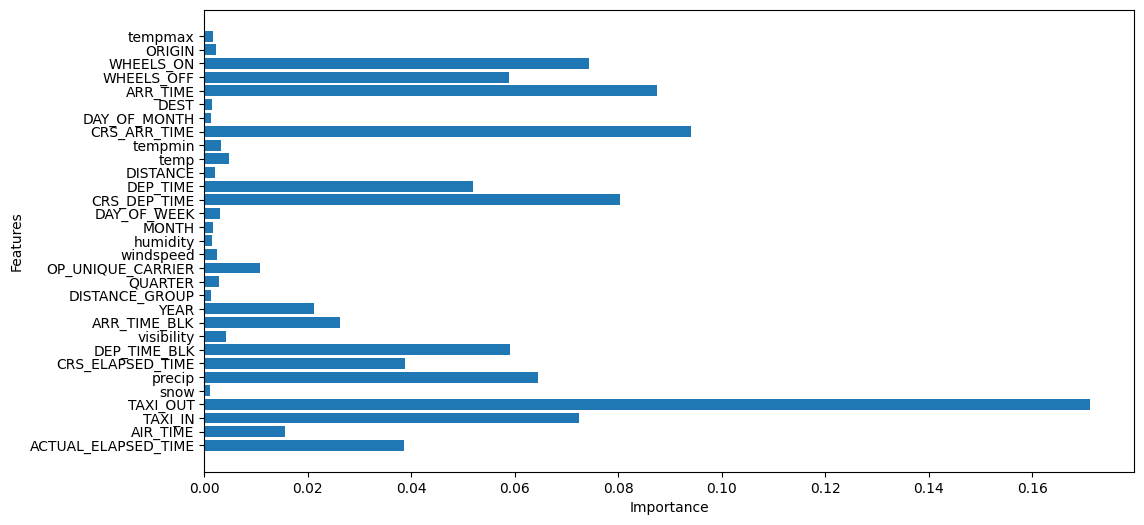

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(y=range(len(model.feature_importances_)), width=model.feature_importances_)
plt.yticks(range(len(model.feature_importances_)), X_train.columns)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()


### checks for GLM

In [ ]:
dp.columns

Index(['ARR_DEL15', 'DEP_DEL15', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'TAXI_IN',
       'TAXI_OUT', 'snow', 'precip', 'CRS_ELAPSED_TIME', 'DEP_TIME_BLK',
       'visibility', 'ARR_TIME_BLK', 'YEAR', 'DISTANCE_GROUP', 'QUARTER',
       'OP_UNIQUE_CARRIER', 'windspeed', 'humidity', 'MONTH', 'DAY_OF_WEEK',
       'CRS_DEP_TIME', 'DEP_TIME', 'DISTANCE', 'temp', 'tempmin',
       'CRS_ARR_TIME', 'DAY_OF_MONTH', 'DEST', 'ARR_TIME', 'WHEELS_OFF',
       'WHEELS_ON', 'ORIGIN', 'tempmax'],
      dtype='object')

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

# Create a GLM model with your response variable and predictor variables
model1 = smf.glm(formula= 'ARR_DEL15 ~ DEP_DEL15+ACTUAL_ELAPSED_TIME+AIR_TIME+TAXI_IN+TAXI_OUT+snow+precip+CRS_ELAPSED_TIME+DEP_TIME_BLK+visibility+ARR_TIME_BLK+YEAR+DISTANCE_GROUP+QUARTER+OP_UNIQUE_CARRIER+windspeed+humidity+MONTH+DAY_OF_WEEK+CRS_DEP_TIME+DEP_TIME+DISTANCE+temp+tempmin+CRS_ARR_TIME+DAY_OF_MONTH+DEST+ARR_TIME+WHEELS_OFF+WHEELS_ON+ORIGIN+tempmax', data=dp, family=sm.families.Binomial())

In [ ]:
# Fit the model and print the summary to evaluate goodness of fit
result = model1.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ARR_DEL15   No. Observations:              2486145
Model:                            GLM   Df Residuals:                  2486112
Model Family:                Binomial   Df Model:                           32
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1809e+05
Date:                Sun, 05 Mar 2023   Deviance:                   6.3616e+05
Time:                        19:12:52   Pearson chi2:                 4.50e+15
No. Iterations:                    20   Pseudo R-squ. (CS):             0.5197
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -34.7610    

In [ ]:
# Check for overdispersion
if result.pearson_chi2 / result.df_resid > 1.5:
    print("Warning: Overdispersion detected. GLM may not be appropriate.")
else:
    print("No overdispersion detected. GLM may be appropriate.")

In [ ]:

# Check for linearity assumption
pred = result.predict(X)
if not (pred > 0).all() and not (pred < 1).all():
    print("Warning: Nonlinear relationship detected. GLM may not be appropriate.")
else:
    print("No nonlinear relationship detected. GLM may be appropriate.")


No nonlinear relationship detected. GLM may be appropriate.


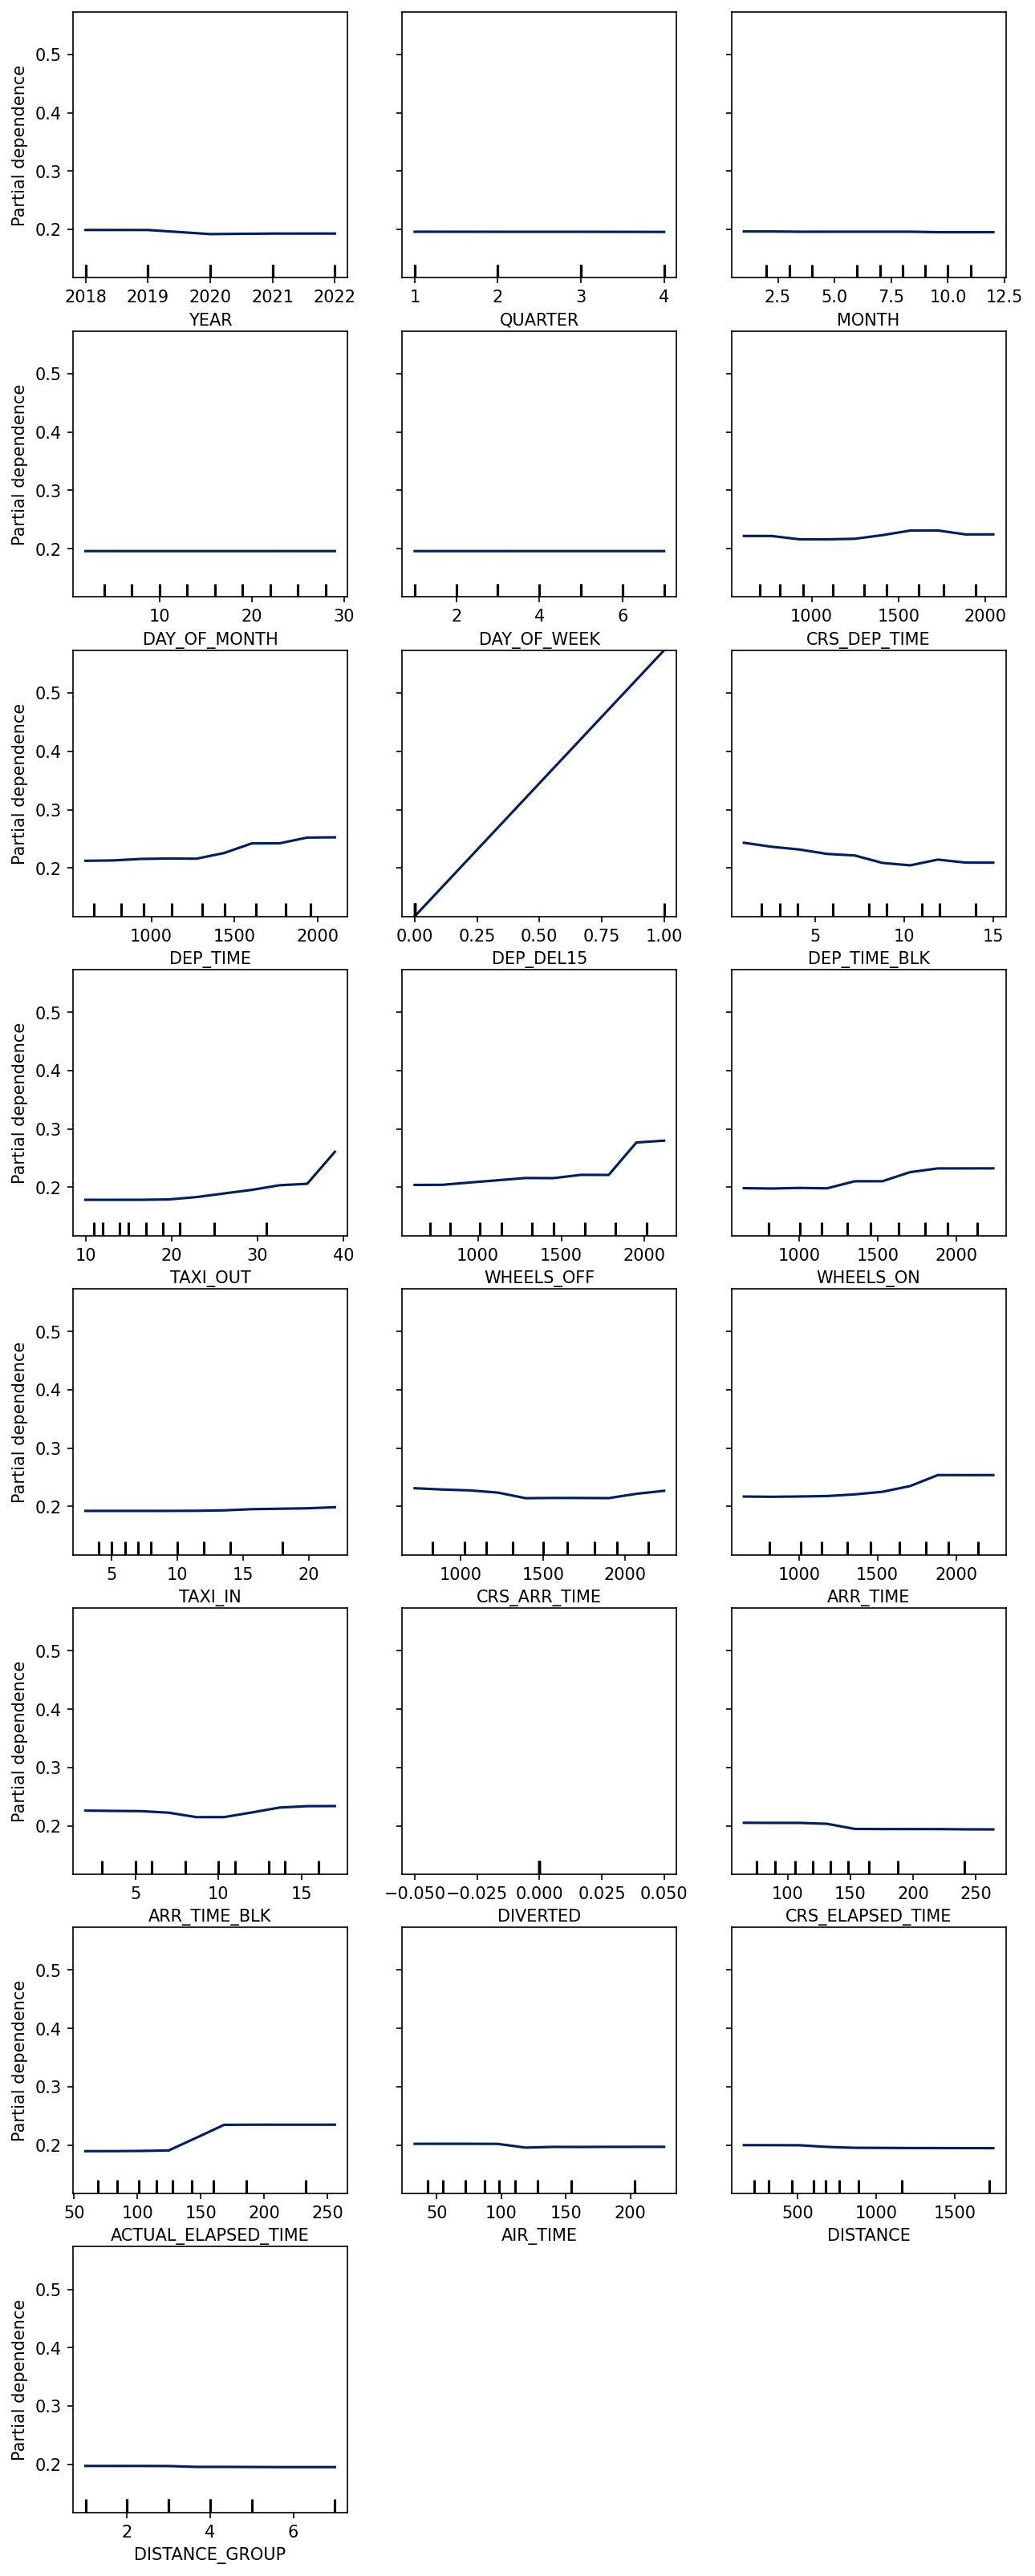

In [ ]:
fig, ax = plt.subplots(figsize=(10, 27))  
display = plot_partial_dependence(
    estimator=model,
    X=X,
    features=[0,1,2,3,4,5,6,7,9,15,16],
    target=1,
    grid_resolution=10,
    ax=ax  
)

plt.show()